In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime,timedelta
from time import time

In [2]:
df = pd.read_csv('catfish.csv',parse_dates=['Date'],index_col=0,squeeze=True)
df.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Name: Total, dtype: int64

In [3]:
#infer the frequency of the data
df = df.asfreq(pd.infer_freq(df.index))
df.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Freq: MS, Name: Total, dtype: int64

In [4]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_df = df[start_date:end_date]

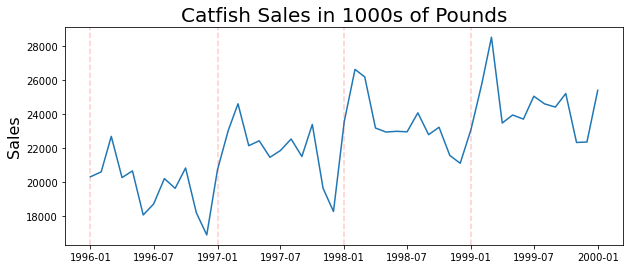

In [5]:
plt.figure(figsize=(10,4))
plt.plot(lim_df)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='r',alpha=0.2)

Clearly there are trends in the pattern and is not stationary

#### Removing the trends

In [6]:
first_diff = lim_df.diff()[1:]
first_diff.tail(),first_diff.head()

(Date
 1999-09-01    -188.0
 1999-10-01     799.0
 1999-11-01   -2885.0
 1999-12-01      28.0
 2000-01-01    3040.0
 Freq: MS, Name: Total, dtype: float64,
 Date
 1996-02-01     291.0
 1996-03-01    2091.0
 1996-04-01   -2428.0
 1996-05-01     393.0
 1996-06-01   -2595.0
 Freq: MS, Name: Total, dtype: float64)

In [7]:
first_difference = (lim_df - lim_df.shift(1))[1:]
first_difference.tail(), first_difference.head()

(Date
 1999-09-01    -188.0
 1999-10-01     799.0
 1999-11-01   -2885.0
 1999-12-01      28.0
 2000-01-01    3040.0
 Freq: MS, Name: Total, dtype: float64,
 Date
 1996-02-01     291.0
 1996-03-01    2091.0
 1996-04-01   -2428.0
 1996-05-01     393.0
 1996-06-01   -2595.0
 Freq: MS, Name: Total, dtype: float64)

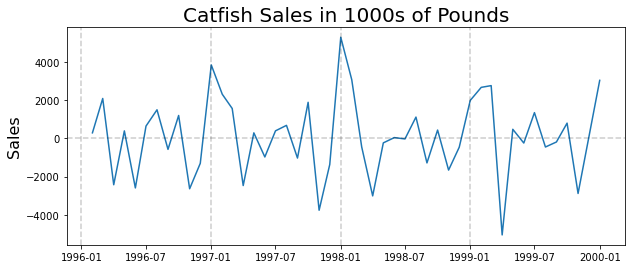

In [8]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

###  Now our series is stationary

C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


<BarContainer object of 20 artists>

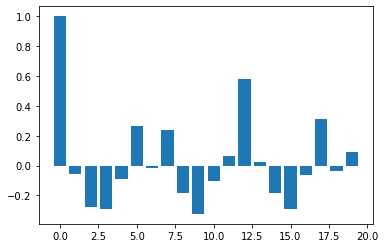

In [9]:
acf_vals = acf(first_diff)
plt.bar(range(20),acf_vals[:20])

Based on ACF, we should start with a seasonal MA process

### PACF

<BarContainer object of 11 artists>

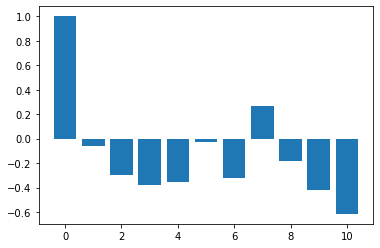

In [10]:
pacf_vals = pacf(first_diff,nlags=10)
plt.bar(range(11), pacf_vals[:11])

### Based on PACF, we should start with a seasonal AR process

### Get training and testing sets

In [11]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_df[:train_end]
test_data = lim_df[train_end + timedelta(days=1):test_end]

In [12]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [13]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.16960382461547852


C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [14]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Fri, 20 Nov 2020   AIC                            737.269
Time:                                      12:56:47   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

In [15]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

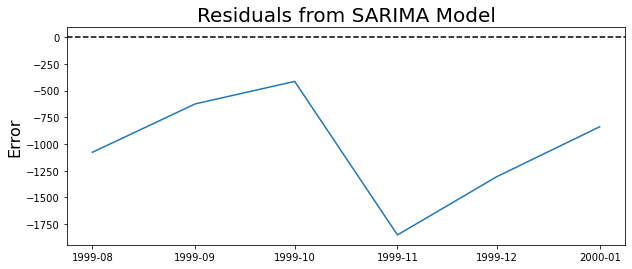

In [16]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

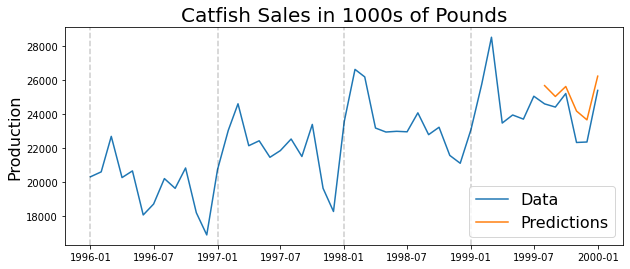

In [17]:
plt.figure(figsize=(10,4))
plt.plot(lim_df)
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [18]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0433


In [19]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.307202058134
